#Make Predictions

* Compare to fine grain, S system, recall results
* I think recall is defined as percentage of correct answers on all instances in test set. Which is what we are doing (basically accuracy)
    * http://www2.denizyuret.com/ref/edmonds/senseval.pdf

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from __future__ import division
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
class WSD:
    
    model_rf = RandomForestClassifier(n_estimators=10)
    model_svm = SVC(kernel='linear', probability=True)
    
    def __init__(self, lex, n_iter=10):
        self.lex = lex
        self.n_iter = n_iter
        
    def _load_data(self, final_dir = "/Users/tylerfolkman/GradSchool/Spring2015/NLP/project/clean/data/test_train",
                 sem_dir = "../data/sem_data/"):
        self.train_X = np.load("{0}/{1}_train_X.npy".format(final_dir, self.lex))
        self.test_X = np.load("{0}/{1}_test_X.npy".format(final_dir, self.lex))
        self.train_target = np.load("{0}/{1}_train_target.npy".format(final_dir, self.lex))
        self.test_target = np.load("{0}/{1}_test_target.npy".format(final_dir, self.lex))

        self.sem_train_X = np.load("{0}/{1}_train_sem.npy".format(sem_dir, self.lex))
        self.sem_test_X = np.load("{0}/{1}_test_sem.npy".format(sem_dir, self.lex))
        
        print(self.sem_train_X.shape)
        print(self.train_X.shape)
        
        self.comb_train_X = np.concatenate([self.train_X, self.sem_train_X], axis=1)
        self.comb_test_X = np.concatenate([self.test_X, self.sem_test_X], axis=1)
        
    def _fit(self, X, y):
        self.model_rf.fit(X, y)
        self.model_svm.fit(X, y)
        self.fimport = self.model_rf.feature_importances_
        
    def _predict(self, X):
        pred_rf_prob = self.model_rf.predict_proba(X)
        pred_svm_prob = self.model_svm.predict_proba(X)
        
        both_max = np.maximum(pred_rf_prob, pred_svm_prob).argmax(axis=1)
        both_mean = np.mean( np.array([ pred_rf_prob, pred_svm_prob ]), axis=0 ).argmax(axis=1)
        rf_max = pred_rf_prob.argmax(axis=1)
        svm_max = pred_svm_prob.argmax(axis=1)
        
        self.pred_rf = self._get_classes(rf_max)
        self.pred_svm = self._get_classes(svm_max)
        self.pred_max = self._get_classes(both_max)
        self.pred_mean = self._get_classes(both_mean)
        
    def _get_classes(self, arg_list):
        assert np.array_equal(self.model_rf.classes_, self.model_svm.classes_)
        pred_classes = []
        for a in arg_list:
            pred_classes.append(self.model_rf.classes_[a])
        return np.array(pred_classes)
        
    def _get_acc(self, y_pred):
        tp = 0
        for i, y in enumerate(self.test_target):
            if y_pred[i] in y:
                tp = tp+1
        return tp / len(y_pred)
    
    def _run_model(self, train_X, test_X):
        acc_dict = defaultdict(list)
        for i in range(self.n_iter):
            self._fit(train_X, self.train_target)
            self._predict(test_X)
            rf_acc = self._get_acc(self.pred_rf)
            svm_acc = self._get_acc(self.pred_svm)
            max_acc = self._get_acc(self.pred_max)
            mean_acc = self._get_acc(self.pred_mean)
            acc_dict['randomForest'].append(rf_acc)
            acc_dict['svm'].append(svm_acc)
            acc_dict['both_max'].append(max_acc)
            acc_dict['both_mean'].append(mean_acc)
        return acc_dict
    
    def _run_all_models(self):
        self._load_data()
        model_dict = defaultdict(dict)
        model_dict['syntax'] = self._run_model(self.train_X, self.test_X)
        model_dict['combined'] = self._run_model(self.comb_train_X, self.comb_test_X)
        model_dict['semantics'] = self._run_model(self.sem_train_X, self.sem_test_X)
        self.model_dict = model_dict
    
    def _to_df(self):
        self.df = pd.DataFrame.from_dict(self.model_dict, orient='index')
    
    def run_all_df(self):
        self._run_all_models()
        self._to_df()
        return self.fimport, self.df
    
    def run_all_save(self, dir_out="../data/predictions/"):
        self._run_all_models()
        self._to_df()
        self.df.to_csv(dir_out + self.lex + ".csv")

In [150]:
#test = WSD('float-v', n_iter=1)
#fimport , df = test.run_all_df()

(183, 5548)
(183, 6087)


<Container object of 10 artists>

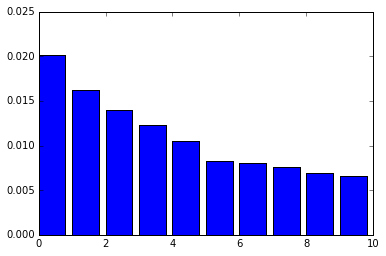

In [151]:
#order = np.sort(fimport)[::-1][:10]
#plt.bar(range(len(order)), order)

In [ ]:
excessn = WSD('excess-n')
excessn.run_all_save()

floatv = WSD('float-v')
floatv.run_all_save()

#brillianta = WSD('brilliant-a')
#brillianta.run_all_save()

accidentn = WSD('accident-n')
accidentn.run_all_save()

promisev = WSD('promise-v')
promisev.run_all_save()

generousa = WSD('generous-a')
generousa.run_all_save()

botherv = WSD('bother-v')
botherv.run_all_save()

derivev = WSD('derive-v')
derivev.run_all_save()

sackn = WSD('sack-n')
sackn.run_all_save()